In [3]:
import pandas as pd
import numpy as np

ts = pd.read_csv("../../notebooks/member1/DATA/total_copy.csv")
cs = pd.read_csv("../../notebooks/member1/DATA/customers_copy.csv")
ac = pd.read_csv("../../notebooks/member1/DATA/articles_copy.csv")

In [61]:
cs.head()

,Customer_Id,Club_Member_Status,Fashion_News_Frequency,Age,Fn_Label,Active_Label,Age_Band
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,ACTIVE,NONE,49,미구독,비활성,40대
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,ACTIVE,NONE,25,미구독,비활성,20대
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,ACTIVE,NONE,24,미구독,비활성,20대
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,ACTIVE,NONE,54,미구독,비활성,50대
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,ACTIVE,REGULARLY,52,구독,활성,50대


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 깨짐 방지(Windows: 맑은 고딕)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

print("ts shape:", ts.shape)
print("cs shape:", cs.shape)
print("ac shape:", ac.shape)


ts shape: (1037772, 10)
cs shape: (1048575, 7)
ac shape: (105542, 12)


In [5]:
print("\n[ts columns]\n", ts.columns.tolist())
print("\n[cs columns]\n", cs.columns.tolist())
print("\n[ac columns]\n", ac.columns.tolist())



[ts columns]
 ['T_Dat', 'Customer_Id', 'Article_Id', 'Revenue', 'Sales_Channel_Id', 'Month', 'Year_Month', 'Month_Day', 'Total_Revenue', 'Revenue_Group']

[cs columns]
 ['Customer_Id', 'Club_Member_Status', 'Fashion_News_Frequency', 'Age', 'Fn_Label', 'Active_Label', 'Age_Band']

[ac columns]
 ['Article_Id', 'Product_Code', 'Prod_Name', 'Product_Type_Info', 'Product_Group_Name', 'Graphical_Appearance_Info', 'Perceived_Colour_Master_Info', 'Department_Info', 'Index_Info', 'Index_Group_Info', 'Section_Info', 'Garment_Group_Info']


In [6]:
ts = ts.copy()
ts.columns = ts.columns.str.strip()

need_ts = ["Customer_Id", "Article_Id", "Sales_Channel_Id"]  
missing_ts = [c for c in need_ts if c not in ts.columns]
print("ts missing:", missing_ts)

# 핵심 컬럼 결측 제거
ts_clean = ts.dropna(subset=need_ts).copy()

# 타입 정리
ts_clean["Sales_Channel_Id"] = ts_clean["Sales_Channel_Id"].astype(int)

# 채널 라벨링 (일반적으로 1=오프라인, 2=온라인)
channel_map = {1: "오프라인", 2: "온라인"}
ts_clean["채널"] = ts_clean["Sales_Channel_Id"].map(channel_map)

print("ts_clean shape:", ts_clean.shape)
print(ts_clean["채널"].value_counts(dropna=False))


ts missing: []
ts_clean shape: (1037772, 11)
채널
온라인     719317
오프라인    318455
Name: count, dtype: int64


In [7]:
cs = cs.copy()
cs.columns = cs.columns.str.strip()

need_cs = ["Customer_Id", "Age_Band"] 
missing_cs = [c for c in need_cs if c not in cs.columns]
print("cs missing:", missing_cs)

cs_clean = cs.copy()

# Age_Band 문자열 정리
cs_clean["Age_Band"] = cs_clean["Age_Band"].astype(str).str.strip()

# 혹시 이런 형태면 통일
cs_clean["Age_Band"] = cs_clean["Age_Band"].replace({
    "60대+": "60대",
    "60대 이상": "60대",
    "70대+": "70대",
    "80대+": "80대",
})

# 90대 제거!
cs_clean = cs_clean[cs_clean["Age_Band"] != "90대"].copy()

age_order = ["10대","20대","30대","40대","50대","60대","70대","80대"]
cs_clean = cs_clean[cs_clean["Age_Band"].isin(age_order)].copy()
cs_clean["Age_Band"] = pd.Categorical(cs_clean["Age_Band"], categories=age_order, ordered=True)

print("cs_clean shape:", cs_clean.shape)
print(cs_clean["Age_Band"].value_counts(dropna=False).sort_index())


cs missing: []
cs_clean shape: (1048503, 7)
Age_Band
10대     55256
20대    409196
30대    181112
40대    157445
50대    174715
60대     56124
70대     13580
80대      1075
Name: count, dtype: int64


In [8]:
analysis = ts_clean.merge(
    cs_clean,                
    on="Customer_Id",
    how="inner"              
)

print("analysis shape:", analysis.shape)
print(analysis[["채널","Age_Band"]].head())


analysis shape: (804555, 17)
     채널 Age_Band
0   온라인      50대
1   온라인      20대
2   온라인      30대
3   온라인      10대
4  오프라인      30대


##매출(거래수) 관점에서 누가 핵심 고객인가를 먼저 규정한다

연령대별 판매량에서 20대가 압도적 1위, 30대가 2위권으로 확인된다.

그런데 고객 1인당 거래건수는 30대(≈2.49)가 20대(≈2.27)보다 높다.
→ 20대는 규모(Volume), 30대는 빈도(Frequency)가 강점인 세그먼트다.
인사이트1. 따라서 성장전략도 20대는 볼륨 확장, 30대는 빈도 레버 최적화로 갈라서 보아야 한다.

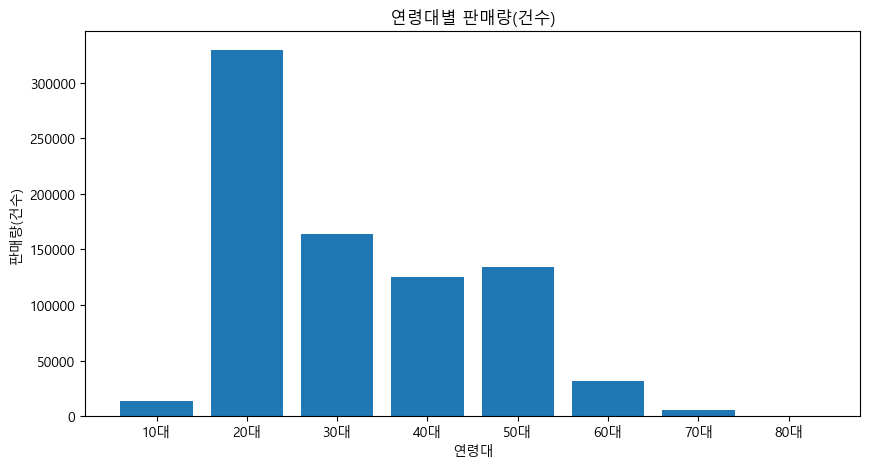

,판매량,구매고객수,고객1인당_거래건수
Age_Band,,,
10대,13706,8679,1.579
20대,329595,145347,2.268
30대,163944,65777,2.492
40대,125414,52994,2.367
50대,134553,60323,2.231
60대,31508,15429,2.042
70대,5429,2954,1.838
80대,406,219,1.854


In [9]:
age_sales = analysis.groupby("Age_Band").size().reindex(age_order)

plt.figure(figsize=(10,5))
plt.bar(age_sales.index.astype(str), age_sales.values)
plt.title("연령대별 판매량(건수)")
plt.xlabel("연령대")
plt.ylabel("판매량(건수)")
plt.xticks(rotation=0)
plt.show()

age_kpi = (
    analysis.groupby("Age_Band")
    .agg(
        판매량=("Customer_Id","size"),
        구매고객수=("Customer_Id","nunique"),
    )
    .reindex(age_order)
)

age_kpi["고객1인당_거래건수"] = (age_kpi["판매량"] / age_kpi["구매고객수"]).round(3)
age_kpi


In [10]:

label_cols = [c for c in ["Fn_Label","Active_Label","Fashion_News_Frequency"] if c in analysis.columns]
print("사용할 라벨 컬럼:", label_cols)

target = analysis[analysis["Age_Band"].isin(["20대","30대"])].copy()

# 라벨별 판매량(건수) / 고객수 / 고객1인당 거래
for col in label_cols:
    tmp = (
        target.groupby(["Age_Band", col])
        .agg(
            판매량=("Customer_Id","size"),
            구매고객수=("Customer_Id","nunique")
        )
        .reset_index()
    )
    tmp["고객1인당_거래건수"] = (tmp["판매량"] / tmp["구매고객수"]).round(3)
    print(f"\n--- [20/30대] {col} 별 KPI ---")
    display(tmp.sort_values(["Age_Band","판매량"], ascending=[True, False]).head(20))


사용할 라벨 컬럼: ['Fn_Label', 'Active_Label', 'Fashion_News_Frequency']

--- [20/30대] Fn_Label 별 KPI ---


,Age_Band,Fn_Label,판매량,구매고객수,고객1인당_거래건수
1,20대,미구독,193438,88054,2.197
0,20대,구독,136157,57293,2.377
3,30대,미구독,98892,41607,2.377
2,30대,구독,65052,24170,2.691



--- [20/30대] Active_Label 별 KPI ---


,Age_Band,Active_Label,판매량,구매고객수,고객1인당_거래건수
0,20대,비활성,195894,89272,2.194
1,20대,활성,133701,56075,2.384
2,30대,비활성,99814,42002,2.376
3,30대,활성,64130,23775,2.697



--- [20/30대] Fashion_News_Frequency 별 KPI ---


,Age_Band,Fashion_News_Frequency,판매량,구매고객수,고객1인당_거래건수
1,20대,NONE,192916,87838,2.196
2,20대,REGULARLY,136599,57449,2.378
0,20대,MONTHLY,80,60,1.333
4,30대,NONE,98643,41504,2.377
5,30대,REGULARLY,65243,24235,2.692
3,30대,MONTHLY,58,38,1.526


In [11]:
# 컬럼명 공백 제거
ts = ts.copy(); ts.columns = ts.columns.str.strip()
cs = cs.copy(); cs.columns = cs.columns.str.strip()

# (1) ts에 반드시 있어야 하는 키 3개만 체크 
need_ts = ["Customer_Id", "Article_Id", "Sales_Channel_Id"]
missing_ts = [c for c in need_ts if c not in ts.columns]
print("ts missing:", missing_ts)

# (2) cs에서 가져올 컬럼
need_cs = ["Customer_Id", "Age_Band", "Fn_Label", "Active_Label", "Fashion_News_Frequency"]
missing_cs = [c for c in need_cs if c not in cs.columns]
print("cs missing:", missing_cs)

# (3) 결측 제거(거래 키)
ts_clean = ts.dropna(subset=need_ts).copy()

# (4) 채널 라벨링 (1=오프라인, 2=온라인)
ts_clean["Sales_Channel_Id"] = ts_clean["Sales_Channel_Id"].astype(int)
channel_map = {1:"오프라인", 2:"온라인"}
ts_clean["채널"] = ts_clean["Sales_Channel_Id"].map(channel_map)

# (5) cs 붙이기 (Age_Band/라벨 가져오기)
analysis = ts_clean.merge(cs[need_cs], on="Customer_Id", how="left")

# (6) Age_Band 표준화 + 90대 제거 + 10~80대만 남기기
analysis["Age_Band"] = analysis["Age_Band"].astype(str).str.strip()
analysis["Age_Band"] = analysis["Age_Band"].replace({
    "60대+": "60대", "60대 이상": "60대",
    "70대+": "70대", "80대+": "80대",
})
analysis = analysis[analysis["Age_Band"] != "90대"].copy()

age_order = ["10대","20대","30대","40대","50대","60대","70대","80대"]
analysis = analysis[analysis["Age_Band"].isin(age_order)].copy()
analysis["Age_Band"] = pd.Categorical(analysis["Age_Band"], categories=age_order, ordered=True)

print("analysis shape:", analysis.shape)
print("채널 분포:\n", analysis["채널"].value_counts(dropna=False))
print("연령대 분포:\n", analysis["Age_Band"].value_counts(dropna=False))


ts missing: []
cs missing: []
analysis shape: (804555, 15)
채널 분포:
 채널
온라인     557851
오프라인    246704
Name: count, dtype: int64
연령대 분포:
 Age_Band
20대    329595
30대    163944
50대    134553
40대    125414
60대     31508
10대     13706
70대      5429
80대       406
Name: count, dtype: int64


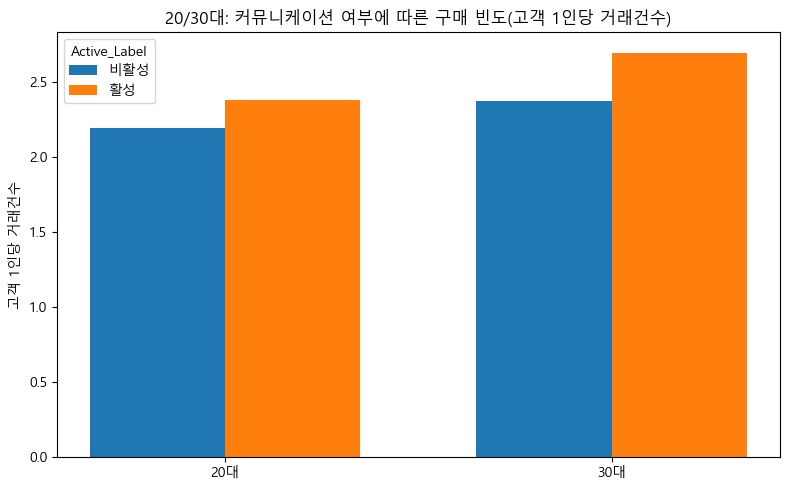

In [27]:
df = analysis.copy()
df_2030 = df[df["Age_Band"].isin(["20대","30대"])].copy()

kpi_active = (
    df_2030.groupby(["Age_Band","Active_Label"])
    .agg(판매량=("Customer_Id","size"), 구매고객수=("Customer_Id","nunique"))
    .reset_index()
)
kpi_active["고객1인당_거래건수"] = kpi_active["판매량"] / kpi_active["구매고객수"]

pivot = kpi_active.pivot(index="Age_Band", columns="Active_Label", values="고객1인당_거래건수").reindex(["20대","30대"])

x = np.arange(len(pivot.index))
w = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - w/2, pivot.get("비활성"), width=w, label="비활성")
plt.bar(x + w/2, pivot.get("활성"), width=w, label="활성")
plt.xticks(x, pivot.index)
plt.ylabel("고객 1인당 거래건수")
plt.title("20/30대: 커뮤니케이션 여부에 따른 구매 빈도(고객 1인당 거래건수)")
plt.legend(title="Active_Label")
plt.tight_layout()
plt.show()


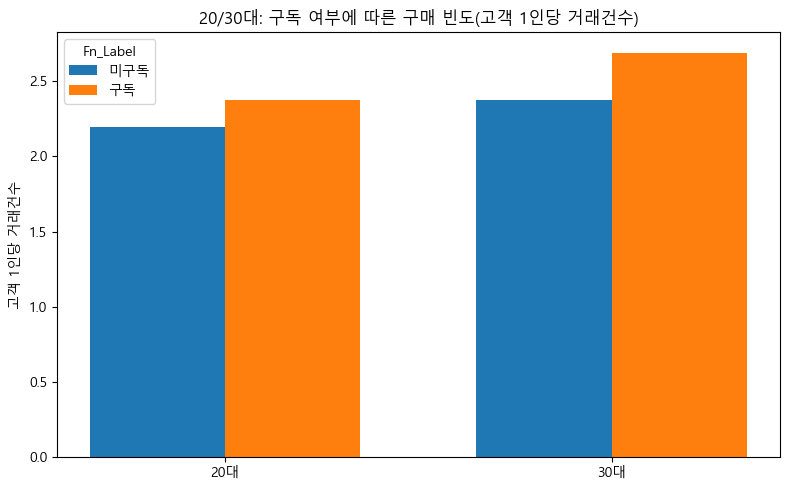

In [13]:
kpi_fn = (
    df_2030.groupby(["Age_Band","Fn_Label"])
    .agg(판매량=("Customer_Id","size"), 구매고객수=("Customer_Id","nunique"))
    .reset_index()
)
kpi_fn["고객1인당_거래건수"] = kpi_fn["판매량"] / kpi_fn["구매고객수"]

pivot = kpi_fn.pivot(index="Age_Band", columns="Fn_Label", values="고객1인당_거래건수").reindex(["20대","30대"])

x = np.arange(len(pivot.index))
w = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - w/2, pivot.get("미구독"), width=w, label="미구독")
plt.bar(x + w/2, pivot.get("구독"), width=w, label="구독")
plt.xticks(x, pivot.index)
plt.ylabel("고객 1인당 거래건수")
plt.title("20/30대: 구독 여부에 따른 구매 빈도(고객 1인당 거래건수)")
plt.legend(title="Fn_Label")
plt.tight_layout()
plt.show()


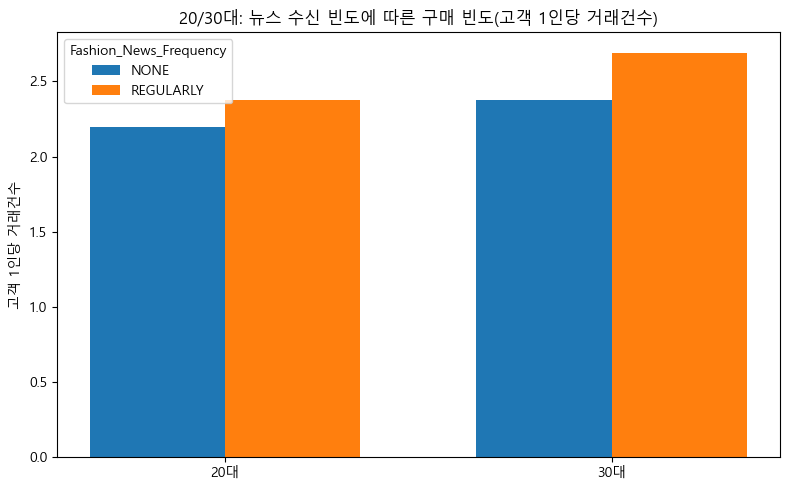

In [14]:
df_news = df_2030[df_2030["Fashion_News_Frequency"].isin(["NONE","REGULARLY"])].copy()

kpi_news = (
    df_news.groupby(["Age_Band","Fashion_News_Frequency"])
    .agg(판매량=("Customer_Id","size"), 구매고객수=("Customer_Id","nunique"))
    .reset_index()
)
kpi_news["고객1인당_거래건수"] = kpi_news["판매량"] / kpi_news["구매고객수"]

pivot = kpi_news.pivot(index="Age_Band", columns="Fashion_News_Frequency", values="고객1인당_거래건수").reindex(["20대","30대"])

x = np.arange(len(pivot.index))
w = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - w/2, pivot.get("NONE"), width=w, label="NONE")
plt.bar(x + w/2, pivot.get("REGULARLY"), width=w, label="REGULARLY")
plt.xticks(x, pivot.index)
plt.ylabel("고객 1인당 거래건수")
plt.title("20/30대: 뉴스 수신 빈도에 따른 구매 빈도(고객 1인당 거래건수)")
plt.legend(title="Fashion_News_Frequency")
plt.tight_layout()
plt.show()


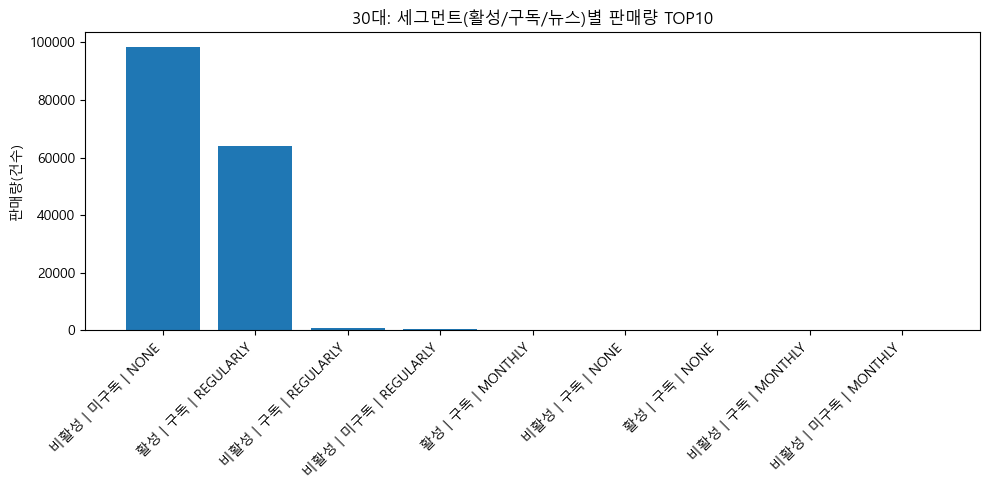

,세그먼트,판매량,구매고객수,고객1인당_거래건수
4,비활성 | 미구독 | NONE,98590,41471,2.377324
8,활성 | 구독 | REGULARLY,64052,23722,2.700110
2,비활성 | 구독 | REGULARLY,890,378,2.354497
5,비활성 | 미구독 | REGULARLY,301,135,2.229630
6,활성 | 구독 | MONTHLY,52,34,1.529412
1,비활성 | 구독 | NONE,27,14,1.928571
7,활성 | 구독 | NONE,26,19,1.368421
0,비활성 | 구독 | MONTHLY,5,3,1.666667
3,비활성 | 미구독 | MONTHLY,1,1,1.000000


In [15]:
df30 = df_2030[df_2030["Age_Band"]=="30대"].copy()

seg30 = (
    df30.groupby(["Active_Label","Fn_Label","Fashion_News_Frequency"])
    .agg(판매량=("Customer_Id","size"), 구매고객수=("Customer_Id","nunique"))
    .reset_index()
)
seg30["고객1인당_거래건수"] = seg30["판매량"] / seg30["구매고객수"]

# 라벨 만들기
seg30["세그먼트"] = (
    seg30["Active_Label"].astype(str) + " | " +
    seg30["Fn_Label"].astype(str) + " | " +
    seg30["Fashion_News_Frequency"].astype(str)
)

top10 = seg30.sort_values("판매량", ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(top10["세그먼트"], top10["판매량"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("판매량(건수)")
plt.title("30대: 세그먼트(활성/구독/뉴스)별 판매량 TOP10")
plt.tight_layout()
plt.show()

# 표
top10[["세그먼트","판매량","구매고객수","고객1인당_거래건수"]]


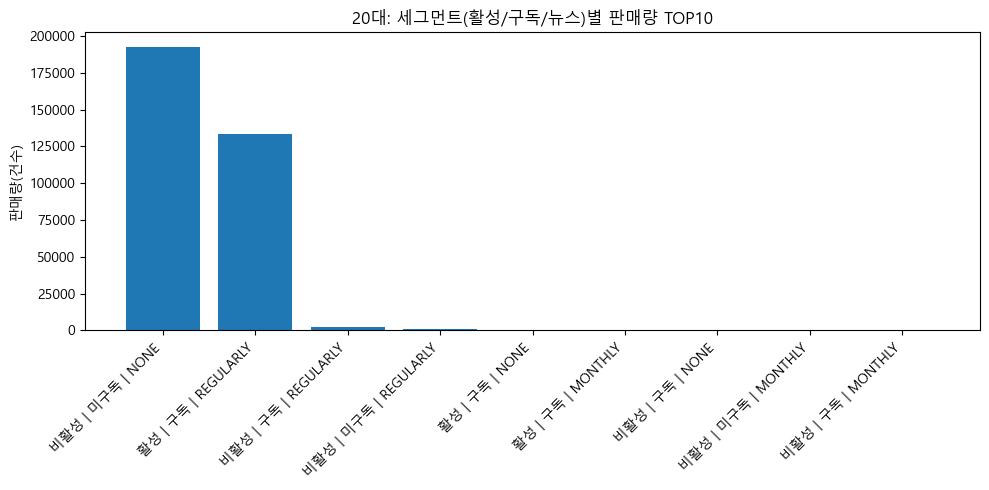

,세그먼트,판매량,구매고객수,고객1인당_거래건수
4,비활성 | 미구독 | NONE,192786,87777,2.196316
8,활성 | 구독 | REGULARLY,133546,55975,2.385815
2,비활성 | 구독 | REGULARLY,2403,1198,2.005843
5,비활성 | 미구독 | REGULARLY,650,276,2.355072
7,활성 | 구독 | NONE,78,42,1.857143
6,활성 | 구독 | MONTHLY,77,58,1.327586
1,비활성 | 구독 | NONE,52,19,2.736842
3,비활성 | 미구독 | MONTHLY,2,1,2.000000
0,비활성 | 구독 | MONTHLY,1,1,1.000000


In [16]:
df20 = df_2030[df_2030["Age_Band"]=="20대"].copy()

seg20 = (
    df20.groupby(["Active_Label","Fn_Label","Fashion_News_Frequency"])
    .agg(판매량=("Customer_Id","size"), 구매고객수=("Customer_Id","nunique"))
    .reset_index()
)
seg20["고객1인당_거래건수"] = seg20["판매량"] / seg20["구매고객수"]

seg20["세그먼트"] = (
    seg20["Active_Label"].astype(str) + " | " +
    seg20["Fn_Label"].astype(str) + " | " +
    seg20["Fashion_News_Frequency"].astype(str)
)

top10_20 = seg20.sort_values("판매량", ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(top10_20["세그먼트"], top10_20["판매량"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("판매량(건수)")
plt.title("20대: 세그먼트(활성/구독/뉴스)별 판매량 TOP10")
plt.tight_layout()
plt.show()

top10_20[["세그먼트","판매량","구매고객수","고객1인당_거래건수"]]


구매빈도를 올리는 레버(행동/관계 변수)”찾는다

20/30대에서 3가지 라벨이 구매빈도(고객 1인당 거래건수)를 얼마나 올리는지 비교한다.

활성(Active): 20대 +0.19 내외, 30대 +0.32 내외
구독(Fn): 20대 +0.18 내외, 30대 +0.31 내외
정기 뉴스 수신(Regularly): 20대 +0.18 내외, 30대 +0.315 내외

→ 결론: 세 레버 모두 있을 때 구매빈도가 상승하며, 특히 30대에서 상승폭이 더 크다.
인사이트2.  30대는(활성·구독·뉴스)가 구매를 더 강하게 끌어올리는 구조다.

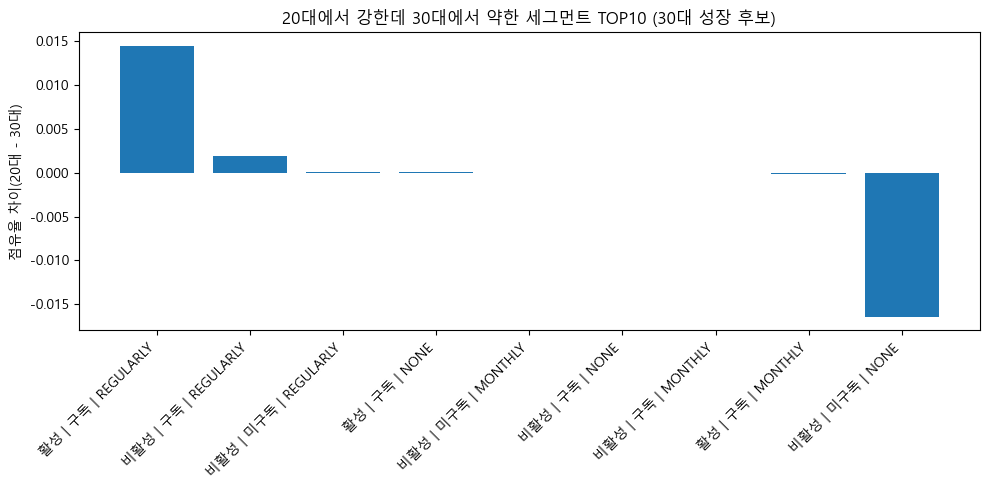

,세그먼트,판매량_20,점유율_20,판매량_30,점유율_30,점유율_갭(20-30)
8,활성 | 구독 | REGULARLY,133546,0.405182,64052,0.390694,1.448773e-02
2,비활성 | 구독 | REGULARLY,2403,0.007291,890,0.005429,1.862083e-03
5,비활성 | 미구독 | REGULARLY,650,0.001972,301,0.001836,1.361245e-04
7,활성 | 구독 | NONE,78,0.000237,26,0.000159,7.806334e-05
3,비활성 | 미구독 | MONTHLY,2,0.000006,1,0.000006,-3.159056e-08
1,비활성 | 구독 | NONE,52,0.000158,27,0.000165,-6.920998e-06
0,비활성 | 구독 | MONTHLY,1,0.000003,5,0.000030,-2.746419e-05
6,활성 | 구독 | MONTHLY,77,0.000234,52,0.000317,-8.356143e-05
4,비활성 | 미구독 | NONE,192786,0.584918,98590,0.601364,-1.644603e-02


In [17]:
def make_seg(df_age):
    seg = (
        df_age.groupby(["Active_Label","Fn_Label","Fashion_News_Frequency"])
        .size().reset_index(name="판매량")
    )
    seg["세그먼트"] = (
        seg["Active_Label"].astype(str) + " | " +
        seg["Fn_Label"].astype(str) + " | " +
        seg["Fashion_News_Frequency"].astype(str)
    )
    seg["점유율"] = seg["판매량"] / seg["판매량"].sum()
    return seg[["세그먼트","판매량","점유율"]]

seg20_s = make_seg(df20)
seg30_s = make_seg(df30)

comp = seg20_s.merge(seg30_s, on="세그먼트", how="outer", suffixes=("_20","_30")).fillna(0)
comp["점유율_갭(20-30)"] = comp["점유율_20"] - comp["점유율_30"]

# 20대에서 더 강한 세그먼트 TOP10
gap_top = comp.sort_values("점유율_갭(20-30)", ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(gap_top["세그먼트"], gap_top["점유율_갭(20-30)"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("점유율 차이(20대 - 30대)")
plt.title("20대에서 강한데 30대에서 약한 세그먼트 TOP10 (30대 성장 후보)")
plt.tight_layout()
plt.show()

gap_top


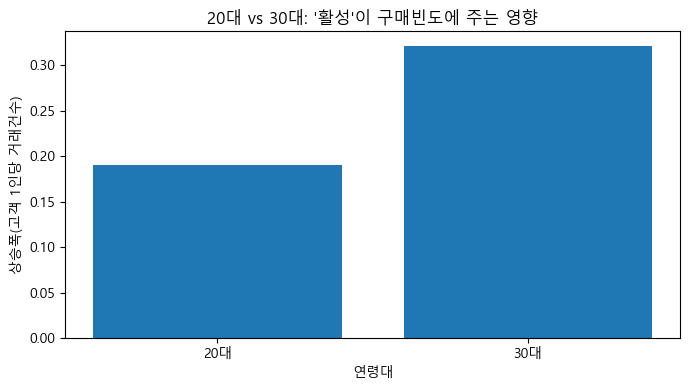

   연령대  상승폭(고객1인당 거래건수)
0  20대         0.189975
1  30대         0.320961


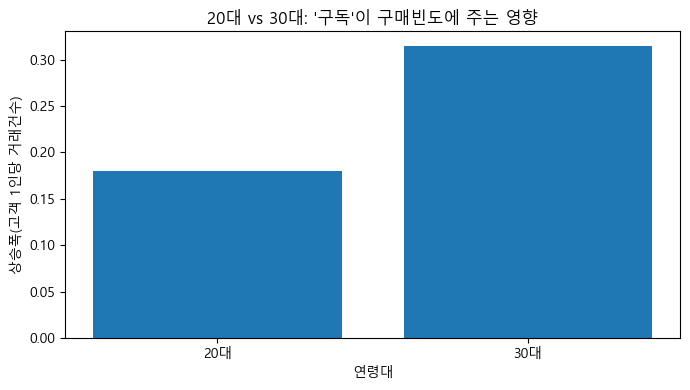

   연령대  상승폭(고객1인당 거래건수)
0  20대         0.179692
1  30대         0.314624


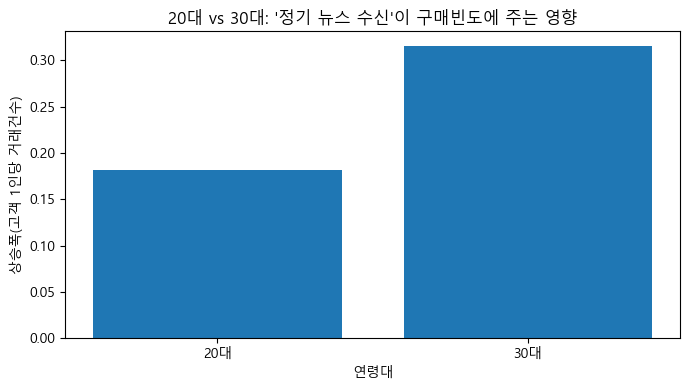

   연령대  상승폭(고객1인당 거래건수)
0  20대         0.181473
1  30대         0.315388


In [20]:
def kpi_by_label(df, age_band, label_col):
    tmp = df[df["Age_Band"] == age_band].copy()
    g = tmp.groupby(label_col).agg(
        판매량=("Customer_Id", "size"),
        구매고객수=("Customer_Id", "nunique")
    )
    g["고객1인당_거래건수"] = g["판매량"] / g["구매고객수"]
    return g.reset_index()

def plot_uplift(df, label_col, title, baseline_value, uplift_value):
    # baseline_value -> uplift_value 차이를 age별로 계산
    rows = []
    for age in ["20대","30대"]:
        k = kpi_by_label(df, age, label_col)
        base = k.loc[k[label_col] == baseline_value, "고객1인당_거래건수"].values
        up = k.loc[k[label_col] == uplift_value, "고객1인당_거래건수"].values
        if len(base)==0 or len(up)==0:
            continue
        rows.append([age, float(up[0] - base[0])])
    uplift_df = pd.DataFrame(rows, columns=["연령대","상승폭(고객1인당 거래건수)"])

    plt.figure(figsize=(7,4))
    plt.bar(uplift_df["연령대"], uplift_df["상승폭(고객1인당 거래건수)"])
    plt.title(title)
    plt.xlabel("연령대")
    plt.ylabel("상승폭(고객 1인당 거래건수)")
    plt.tight_layout()
    plt.show()

    return uplift_df

# (1) 활성 uplift: 비활성 -> 활성
uplift_active = plot_uplift(
    analysis,
    label_col="Active_Label",
    title="20대 vs 30대: '활성'이 구매빈도에 주는 영향",
    baseline_value="비활성",
    uplift_value="활성"
)
print(uplift_active)

# (2) 구독 uplift: 미구독 -> 구독
uplift_fn = plot_uplift(
    analysis,
    label_col="Fn_Label",
    title="20대 vs 30대: '구독'이 구매빈도에 주는 영향",
    baseline_value="미구독",
    uplift_value="구독"
)
print(uplift_fn)

# (3) 뉴스 uplift: NONE -> REGULARLY
uplift_news = plot_uplift(
    analysis,
    label_col="Fashion_News_Frequency",
    title="20대 vs 30대: '정기 뉴스 수신'이 구매빈도에 주는 영향",
    baseline_value="NONE",
    uplift_value="REGULARLY"
)
print(uplift_news)


In [22]:
import matplotlib.pyplot as plt
import pandas as pd


plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.family"] = "Malgun Gothic"  # 윈도우면 보통 이게 됨

# 공통 KPI 함수 
def make_kpi(df, group_cols):
    tmp = (df
           .groupby(group_cols)
           .agg(판매량=("Customer_Id", "size"),
                구매고객수=("Customer_Id", "nunique"))
           .reset_index())
    tmp["고객1인당_거래건수"] = tmp["판매량"] / tmp["구매고객수"]
    return tmp

# 20/30대만
a2030 = analysis[analysis["Age_Band"].isin(["20대","30대"])].copy()

# 교집합 세그먼트 라벨
a2030["세그먼트"] = (
    a2030["Active_Label"].astype(str) + " | " +
    a2030["Fn_Label"].astype(str) + " | " +
    a2030["Fashion_News_Frequency"].astype(str)
)

# 채널 라벨(1/2 -> 오프/온)
a2030["Sales_Channel_Id"] = a2030["Sales_Channel_Id"].astype(int)
a2030["채널"] = a2030["Sales_Channel_Id"].map({1:"오프라인", 2:"온라인"})


In [23]:
print("analysis cols:", analysis.columns.tolist())
print("ac cols:", ac.columns.tolist())


analysis cols: ['T_Dat', 'Customer_Id', 'Article_Id', 'Revenue', 'Sales_Channel_Id', 'Month', 'Year_Month', 'Month_Day', 'Total_Revenue', 'Revenue_Group', '채널', 'Age_Band', 'Fn_Label', 'Active_Label', 'Fashion_News_Frequency']
ac cols: ['Article_Id', 'Product_Code', 'Prod_Name', 'Product_Type_Info', 'Product_Group_Name', 'Graphical_Appearance_Info', 'Perceived_Colour_Master_Info', 'Department_Info', 'Index_Info', 'Index_Group_Info', 'Section_Info', 'Garment_Group_Info']


In [24]:
import pandas as pd
import numpy as np
import re

ac = ac.copy()
ac.columns = ac.columns.astype(str).str.strip()

# Article_Id 컬럼
if "Article_Id" not in ac.columns:
    # 비슷한 이름 찾기(Article + Id)
    cand = [c for c in ac.columns if ("article" in c.lower() and "id" in c.lower())]
    if len(cand) == 0:
        raise ValueError(f"ac에서 Article_Id 못 찾음. columns 예시: {list(ac.columns)[:30]}")
    ac = ac.rename(columns={cand[0]: "Article_Id"})

print("ac Article_Id:", "Article_Id")

# 카테고리 후보 찾기
def pick_category_candidates(df, id_cols=("Article_Id",), max_unique_ratio=0.20, max_unique=5000):
    n = len(df)
    out = []
    for c in df.columns:
        if c in id_cols:
            continue
        nunq = df[c].nunique(dropna=True)
        ratio = nunq / max(n, 1)

        if nunq <= 1:
            continue
        if ratio > max_unique_ratio:
            continue
        if nunq > max_unique:
            continue

        out.append((c, nunq, ratio))
    return sorted(out, key=lambda x: (x[2], x[1]))  

cands = pick_category_candidates(ac)

print("\n[카테고리 후보 TOP 20]")
if len(cands) == 0:
    print("후보가 0개")
    print(" ac.dtypes 확인:")
    display(ac.dtypes)
else:
    for c, nunq, ratio in cands[:20]:
        print(f"- {c:30s} | unique={nunq:<6d} | unique_ratio={ratio:.6f}")

   
    item_col = cands[0][0]
    print("\n item_col 자동 선택:", item_col)
    print("\n[item_col 값 분포 TOP 20]")
    display(ac[item_col].value_counts(dropna=False).head(20))


ac Article_Id: Article_Id

[카테고리 후보 TOP 20]
- Index_Group_Info               | unique=5      | unique_ratio=0.000047
- Index_Info                     | unique=10     | unique_ratio=0.000095
- Product_Group_Name             | unique=19     | unique_ratio=0.000180
- Perceived_Colour_Master_Info   | unique=20     | unique_ratio=0.000189
- Garment_Group_Info             | unique=21     | unique_ratio=0.000199
- Graphical_Appearance_Info      | unique=30     | unique_ratio=0.000284
- Section_Info                   | unique=57     | unique_ratio=0.000540
- Product_Type_Info              | unique=132    | unique_ratio=0.001251
- Department_Info                | unique=299    | unique_ratio=0.002833

 item_col 자동 선택: Index_Group_Info

[item_col 값 분포 TOP 20]


Index_Group_Info
Ladieswear (1)       39737
Baby/Children (4)    34711
Divided (2)          15149
Menswear (3)         12553
Sport (26)            3392
Name: count, dtype: int64

In [25]:
# 1) cs에서 쓸 컬럼
need_cs = ["Customer_Id", "Fn_Label", "Active_Label", "Fashion_News_Frequency", "Age_Band"]
cs_use = cs[need_cs].copy()

# 2) 거래+고객 조인
df = ts_clean.merge(cs_use, on="Customer_Id", how="left")

# 3) 거래+상품 조인 (item_col 필요)
df = df.merge(ac[["Article_Id", item_col]], on="Article_Id", how="left")

# 4) 20/30대만 + item_col 결측 제거
df2030 = df[df["Age_Band"].isin(["20대", "30대"])].dropna(subset=[item_col]).copy()

print("df2030 shape:", df2030.shape)
print(df2030[["Age_Band", item_col]].head())


df2030 shape: (493539, 16)
  Age_Band Index_Group_Info
1      20대   Ladieswear (1)
2      30대     Menswear (3)
4      30대     Menswear (3)
6      20대   Ladieswear (1)
8      20대   Ladieswear (1)


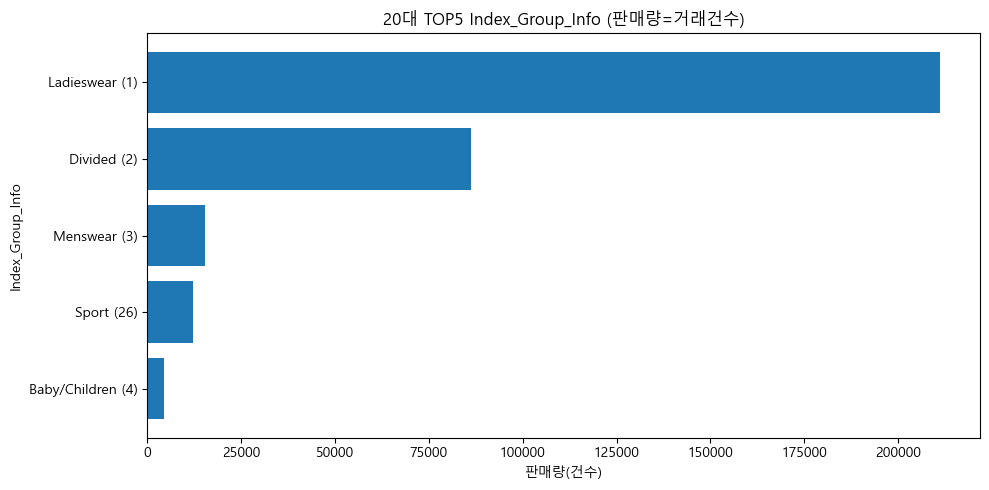

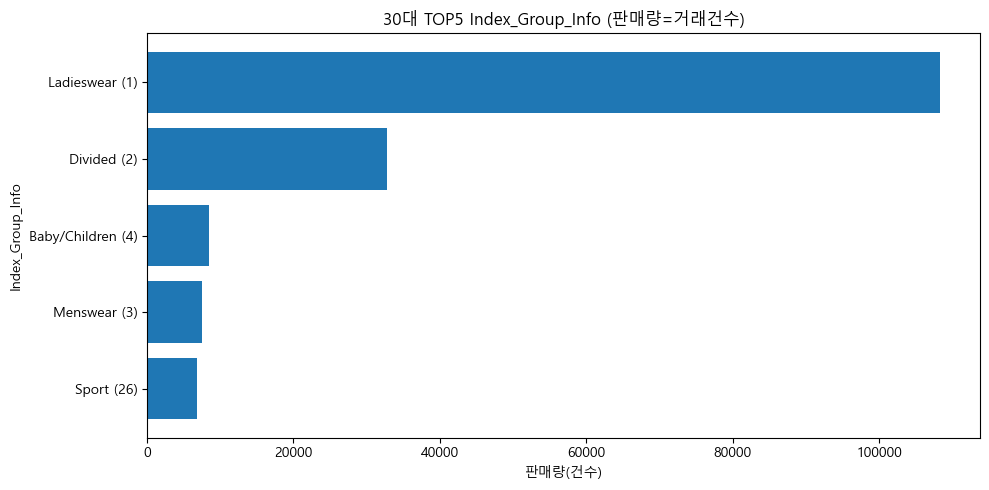

In [ ]:
top = (df2030.groupby(["Age_Band", item_col])
       .size()
       .reset_index(name="판매량")
       .sort_values(["Age_Band","판매량"], ascending=[True, False]))

for age in ["20대", "30대"]:
    tmp = top[top["Age_Band"] == age].head(10).sort_values("판매량")
    plt.figure(figsize=(10,5))
    plt.barh(tmp[item_col].astype(str), tmp["판매량"])
    plt.title(f"{age} TOP5 {item_col} (판매량=거래건수)")
    plt.xlabel("판매량(건수)")
    plt.ylabel(item_col)
    plt.tight_layout()
    plt.show()


In [115]:
print(ts_clean.columns.tolist())
print([c for c in ts_clean.columns if "age" in str(c).lower() or "band" in str(c).lower() or "연" in str(c)])


['T_Dat', 'Customer_Id', 'Article_Id', 'Revenue', 'Sales_Channel_Id', 'Month', 'Year_Month', 'Month_Day', 'Total_Revenue', 'Revenue_Group', '채널']
[]


In [ ]:
# 1) cs에 필요한 컬럼들 
cs_need = ["Customer_Id", "Age_Band", "Fn_Label", "Active_Label", "Fashion_News_Frequency"]
print("cs missing:", [c for c in cs_need if c not in cs.columns])

# 2) ts_clean
df = ts_clean.merge(cs[cs_need], on="Customer_Id", how="left")

print("df columns check:", [c for c in ["Age_Band","Fn_Label","Active_Label","Fashion_News_Frequency"] if c in df.columns])
print("df shape:", df.shape)


cs missing: []
✅ df columns check: ['Age_Band', 'Fn_Label', 'Active_Label', 'Fashion_News_Frequency']
✅ df shape: (1037772, 15)


In [ ]:
# Age_Band 문자열 정리
df["Age_Band"] = df["Age_Band"].astype(str).str.strip()

# 90대 완전 삭제 + 10~80대만 남기기
age_order = ["10대","20대","30대","40대","50대","60대","70대","80대"]
df = df[df["Age_Band"].isin(age_order)].copy()

# 혹시라도 고객정보가 비어있던 거래 제거
df = df.dropna(subset=["Age_Band"]).copy()

# 순서 고정
df["Age_Band"] = pd.Categorical(df["Age_Band"], categories=age_order, ordered=True)

print(df["Age_Band"].value_counts(dropna=False))


Age_Band
20대    329595
30대    163944
50대    134553
40대    125414
60대     31508
10대     13706
70대      5429
80대       406
Name: count, dtype: int64


In [ ]:
# ac에서 필요한 컬럼만
ac_need = ["Article_Id", "Index_Group_Info"]
print("ac missing:", [c for c in ac_need if c not in ac.columns])

df2 = df.merge(ac[ac_need], on="Article_Id", how="left")

print(" df2 shape:", df2.shape)
print(df2["Index_Group_Info"].isna().mean())  # 상품군 결측 비율


ac missing: []
✅ df2 shape: (804555, 16)
0.0


✅ seg shape: (197598, 16)


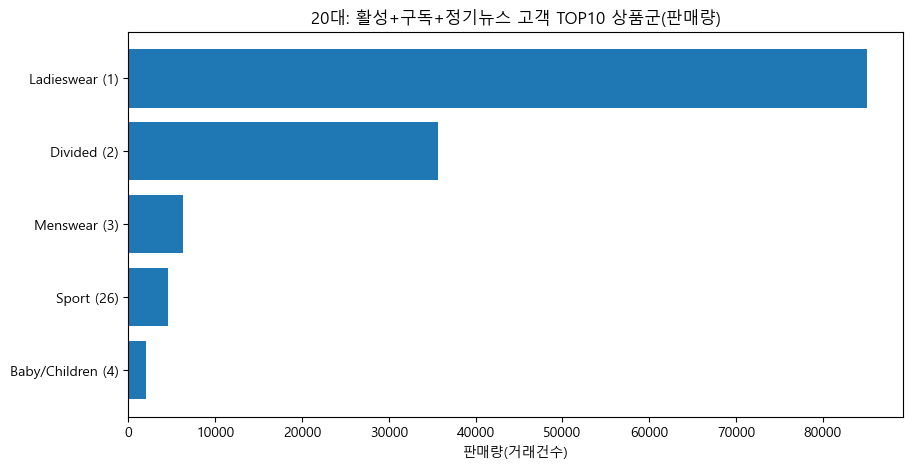

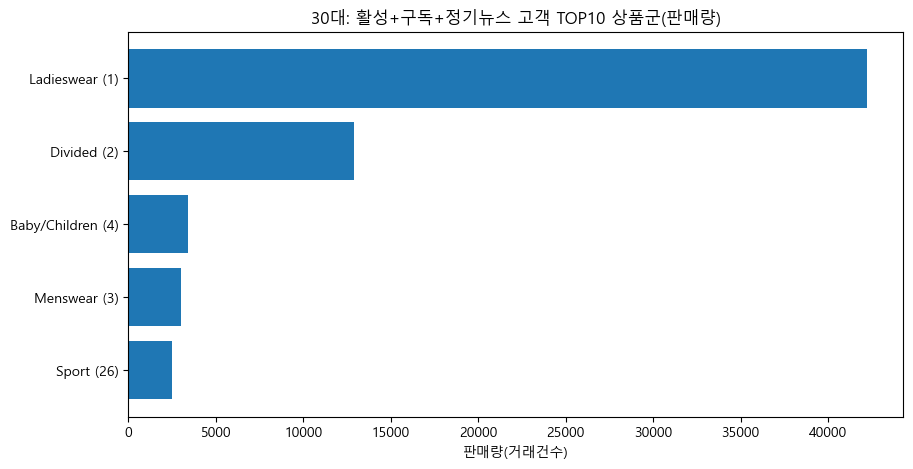

,Age_Band,Index_Group_Info,판매량
0,20대,Baby/Children (4),2044
4,20대,Sport (26),4537
3,20대,Menswear (3),6274
1,20대,Divided (2),35651
2,20대,Ladieswear (1),85040


,Age_Band,Index_Group_Info,판매량
9,30대,Sport (26),2507
8,30대,Menswear (3),3006
5,30대,Baby/Children (4),3417
6,30대,Divided (2),12917
7,30대,Ladieswear (1),42205


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 20/30대만
df2030 = df2[df2["Age_Band"].isin(["20대","30대"])].dropna(subset=["Index_Group_Info"]).copy()

# 교집합 세그먼트(활성+구독+정기뉴스)
seg = df2030[
    (df2030["Active_Label"] == "활성") &
    (df2030["Fn_Label"] == "구독") &
    (df2030["Fashion_News_Frequency"] == "REGULARLY")
].copy()

print(" seg shape:", seg.shape)

# 연령대별 TOP10 상품군
top = (seg.groupby(["Age_Band","Index_Group_Info"])
          .size()
          .reset_index(name="판매량")
          .sort_values(["Age_Band","판매량"], ascending=[True, False]))

top10_20 = top[top["Age_Band"]=="20대"].head(10).sort_values("판매량")
top10_30 = top[top["Age_Band"]=="30대"].head(10).sort_values("판매량")

# 시각화 
plt.figure(figsize=(10,5))
plt.barh(top10_20["Index_Group_Info"], top10_20["판매량"])
plt.title("20대: 활성+구독+정기뉴스 고객 TOP10 상품군(판매량)")
plt.xlabel("판매량(거래건수)")
plt.show()

plt.figure(figsize=(10,5))
plt.barh(top10_30["Index_Group_Info"], top10_30["판매량"])
plt.title("30대: 활성+구독+정기뉴스 고객 TOP10 상품군(판매량)")
plt.xlabel("판매량(거래건수)")
plt.show()

display(top10_20)
display(top10_30)


In [121]:
seg = df2030.copy()

seg["고관여"] = (
    (seg["Active_Label"] == "활성") &
    (seg["Fn_Label"] == "구독") &
    (seg["Fashion_News_Frequency"] == "REGULARLY")
)

# 세그먼트 규모(고객수/판매량=거래건수) 확인
kpi_size = (seg.groupby(["Age_Band","고관여"])
              .agg(판매량=("Article_Id","size"),
                   구매고객수=("Customer_Id","nunique"))
              .reset_index())
kpi_size["고객1인당_거래건수"] = (kpi_size["판매량"] / kpi_size["구매고객수"]).round(3)
kpi_size


,Age_Band,고관여,판매량,구매고객수,고객1인당_거래건수
0,20대,False,196049,89372,2.194
1,20대,True,133546,55975,2.386
2,30대,False,99892,42055,2.375
3,30대,True,64052,23722,2.700


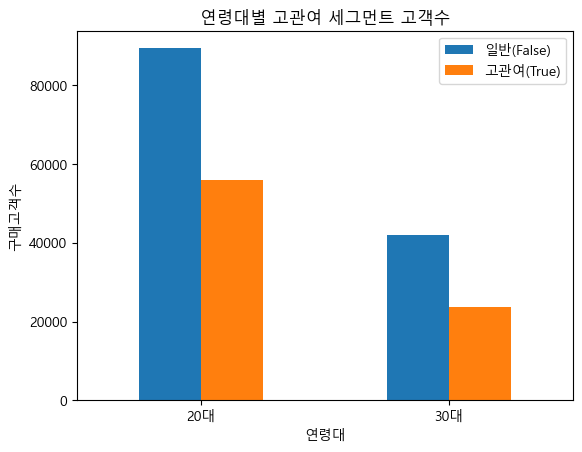

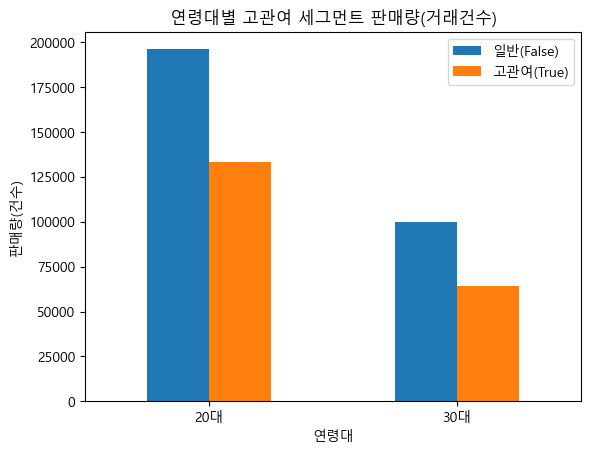

In [122]:
tmp = kpi_size.pivot(index="Age_Band", columns="고관여", values="구매고객수").fillna(0)
tmp.plot(kind="bar", rot=0)
plt.title("연령대별 고관여 세그먼트 고객수")
plt.xlabel("연령대"); plt.ylabel("구매고객수")
plt.legend(["일반(False)","고관여(True)"])
plt.show()

tmp2 = kpi_size.pivot(index="Age_Band", columns="고관여", values="판매량").fillna(0)
tmp2.plot(kind="bar", rot=0)
plt.title("연령대별 고관여 세그먼트 판매량(거래건수)")
plt.xlabel("연령대"); plt.ylabel("판매량(건수)")
plt.legend(["일반(False)","고관여(True)"])
plt.show()


고관여(활성+구독+정기뉴스) 세그먼트를 성장 타깃으로 정의한다

연령대별 고관여 고객수/판매량 그래프에서

20대는 고관여 절대 규모가 크고
30대는 고관여 규모는 작지만 고관여 전환 시 얻는 추가 구매빈도(상승폭)가 더 큼

인사이트3.  30대는 전환 효율(레버 효과)이 높은 집단이라, 고객관리를 해서 사람을 고관여 상태로 만들면, 그 사람들이 더 자주 사서 판매량이 늘어난다. 특히 30대는 그 효과가 더 커서, 들인 노력/비용 대비 얻는 결과가 더 크다.
 동시에, 20대에서 강하고 30대에서 약한 세그먼트 그래프는 30대에 아직 고관여 침투가 덜 됐다는 신호로 해석 가능하다(성장 여지).

CRM: 고객을 한 번 사게가 아니라 계속 사게 만들기 위한 관계/리텐션 관리 활동
ROI: 투자 대비 수익률.

In [123]:
item_col = "Index_Group_Info"

top = (seg[seg["고관여"]]
       .groupby(["Age_Band", item_col])
       .size()
       .reset_index(name="판매량")
       .sort_values(["Age_Band","판매량"], ascending=[True, False]))

top10_20 = top[top["Age_Band"]=="20대"].head(10).sort_values("판매량")
top10_30 = top[top["Age_Band"]=="30대"].head(10).sort_values("판매량")

top10_20, top10_30


(  Age_Band   Index_Group_Info    판매량
 0      20대  Baby/Children (4)   2044
 4      20대         Sport (26)   4537
 3      20대       Menswear (3)   6274
 1      20대        Divided (2)  35651
 2      20대     Ladieswear (1)  85040,
   Age_Band   Index_Group_Info    판매량
 9      30대         Sport (26)   2507
 8      30대       Menswear (3)   3006
 5      30대  Baby/Children (4)   3417
 6      30대        Divided (2)  12917
 7      30대     Ladieswear (1)  42205)

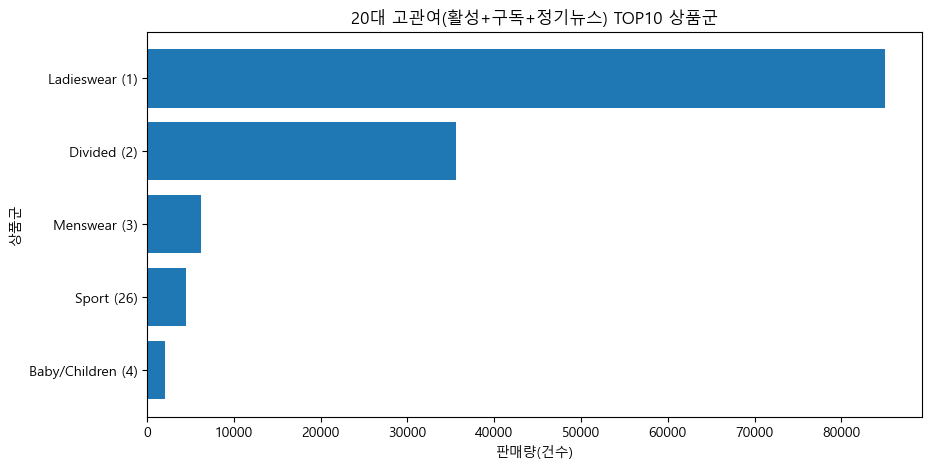

In [ ]:
plt.figure(figsize=(10,5))
plt.barh(top10_20[item_col], top10_20["판매량"])
plt.title("20대 고관여(활성+구독+정기뉴스) TOP5 상품군")
plt.xlabel("판매량(건수)"); plt.ylabel("상품군")
plt.show()


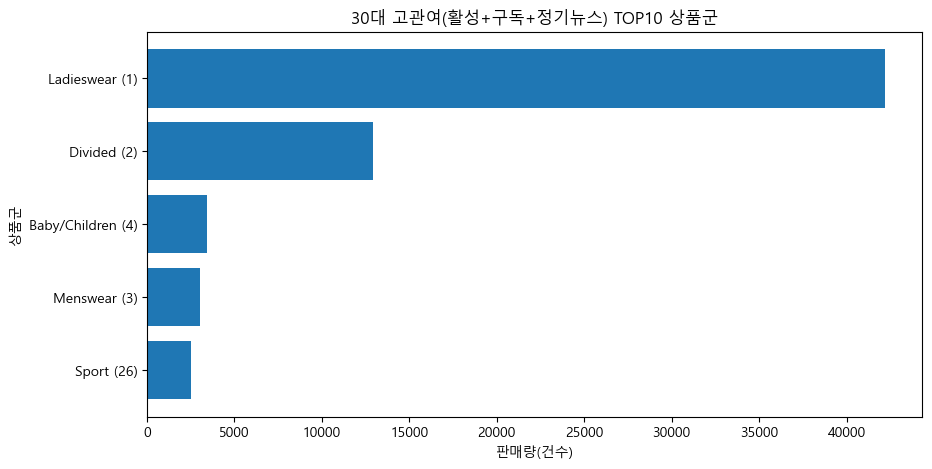

In [ ]:
plt.figure(figsize=(10,5))
plt.barh(top10_30[item_col], top10_30["판매량"])
plt.title("30대 고관여(활성+구독+정기뉴스) TOP5 상품군")
plt.xlabel("판매량(건수)"); plt.ylabel("상품군")
plt.show()


4. 그럼 고관여 고객이 실제로 무엇을 사는가를 본다 

20대/30대 고관여 고객 TOP 상품군에서 공통적으로
1위: Ladieswear, 2위: Divided가 압도적이다.

30대는 고관여 TOP에서 Baby/Children 비중이 상대적으로 더 눈에 띈다
→ 결론: 성장 레버(고관여 전환)를 Ladieswear / Divided 판매 확대로 연결시키는 전략이 가장 직관적이다.
→ 특히 30대는 관계 레버 효과가 큰데, 실제 구매는 Ladieswear 중심이라 CRM→카테고리 매출로 직결시키기 쉽다.

인사이트4. Ladieswear / Divided를 더 잘 팔기 위한 실행 전략으로 연결한다

20대: 규모가 크므로 도달/전환 최적화 + 트렌드로 볼륨을 키운다.
30대: 고관여 전환 효과가 크므로 고관여 전환(CRM) + 재구매 루프로 빈도를 키운다.

두 연령 모두, 매출의 대부분이 1~2위 카테고리에 쏠려 있으므로 카테고리 내에서 반복 구매가 가능한 상품(베이직/이너/세트/시즌 필수)을 중심으로 설계한다.

핵심 인사이트! 

1. 20대는 고객 규모/거래량의 엔진이다.

2. 30대는 1인당 구매빈도가 더 높아 성장 효율이 좋다.

3. 활성/구독/정기뉴스는 모두 구매빈도를 올리며, 30대에서 효과가 더 강하다(≈+0.31~0.32).

4. 고관여 세그먼트는 20대에 더 많이 존재하지만, 30대는 전환 시 추가 성과가 더 크게 발생한다.

5. 고관여 고객의 구매는 연령 상관없이 Ladieswear + Divided에 강하게 집중된다.

6. 30대 고관여에서 Baby/Children이 상대적으로 보이므로, 30대는 지금 삶의 상황에 따라 같이 필요해지는 제품 조합이 생기니까, 그 조합을 미리 묶어서 추천/판매하면 더 잘 팔릴 수 있다

1. 30대 전략: 고관여 전환 → Ladieswear 반복구매 루프

가설: 30대는 활성/구독/뉴스가 구매빈도를 크게 올리므로, 고관여로 끌어올리면 Ladieswear 매출이 빠르게 커진다.

CRM/콘텐츠
정기뉴스를 단순 홍보가 아니라 ‘코디/상황별 캡슐 추천(출근/주말/행사)’로 구성한다.
뉴스 안 CTA를 “신상 구경”이 아니라 ‘바로 장바구니 완성(세트/코디 통째)’로 설계한다.

상품
30대는 재구매 가능한 실용 카테고리가 강해지기 쉬움 → 베이직 탑/이너/니트/아우터/오피스웨어 같이 시즌 반복 품목을 중심으로 큐레이션한다.

30대 고관여에서 Baby/Children이 보이므로
‘엄마/가족 라이프’ 테마 느낌으로 (여성 의류 + 키즈/베이비 소량 크로스셀)을 테스트해본다!

프로모션 구조
첫 구독 할인보다 구독 유지형(월 1회 캡슐/무료배송/세트 할인)이 구매빈도 지표에 더 직결된다.

검증 KPI
(1) 30대 고관여 전환율, (2) 전환 후 30일/60일 재구매율, (3) Ladieswear 구매빈도(거래/고객) 변화

4-2. 20대 전략: Divided 중심 트렌드/드롭 + 저항 없는 구독 유도

가설: 20대는 규모가 크고 Divided 비중이 높으므로, 트렌드 드라이브로 거래량을 키우되 구독/뉴스는 귀찮음 최소’로 설계해야 한다.

콘텐츠/유입
Divided는 트렌드 영향이 커서 드롭(신상 캘린더), 한정 컬러, 룩북형 뉴스가 잘 먹힌다.

구독 전환
20대는 혜택 복잡함에 이탈이 생기기 쉬움 →구독=맞춤 추천 강화/알림 최소화/관심 스타일만 같이 “통제감”을 주는 방식으로 유도한다.

검증 KPI
Divided 거래수, 신상 도달 대비 전환, 뉴스 수신자의 클릭→구매 전환율